100%|██████████| 2.64G/2.64G [02:43<00:00, 16.1MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 173MB/s]


Epoch [1/10], Train Acc: 14.92%, Val Acc: 22.56%, Train Loss: 2.4533, Val Loss: 2.0539
Epoch [2/10], Train Acc: 24.50%, Val Acc: 24.90%, Train Loss: 1.9726, Val Loss: 1.9341
Epoch [3/10], Train Acc: 29.62%, Val Acc: 31.65%, Train Loss: 1.7852, Val Loss: 1.6775
Epoch [4/10], Train Acc: 36.50%, Val Acc: 40.73%, Train Loss: 1.6481, Val Loss: 1.5530
Epoch [5/10], Train Acc: 39.40%, Val Acc: 39.81%, Train Loss: 1.5750, Val Loss: 1.5363
Epoch [6/10], Train Acc: 41.16%, Val Acc: 42.76%, Train Loss: 1.5084, Val Loss: 1.5159
Epoch [7/10], Train Acc: 45.48%, Val Acc: 44.62%, Train Loss: 1.4193, Val Loss: 1.5074
Epoch [8/10], Train Acc: 49.22%, Val Acc: 48.41%, Train Loss: 1.3474, Val Loss: 1.3844
Epoch [9/10], Train Acc: 52.54%, Val Acc: 46.79%, Train Loss: 1.2578, Val Loss: 1.5235
Epoch [10/10], Train Acc: 56.54%, Val Acc: 50.89%, Train Loss: 1.1699, Val Loss: 1.3543


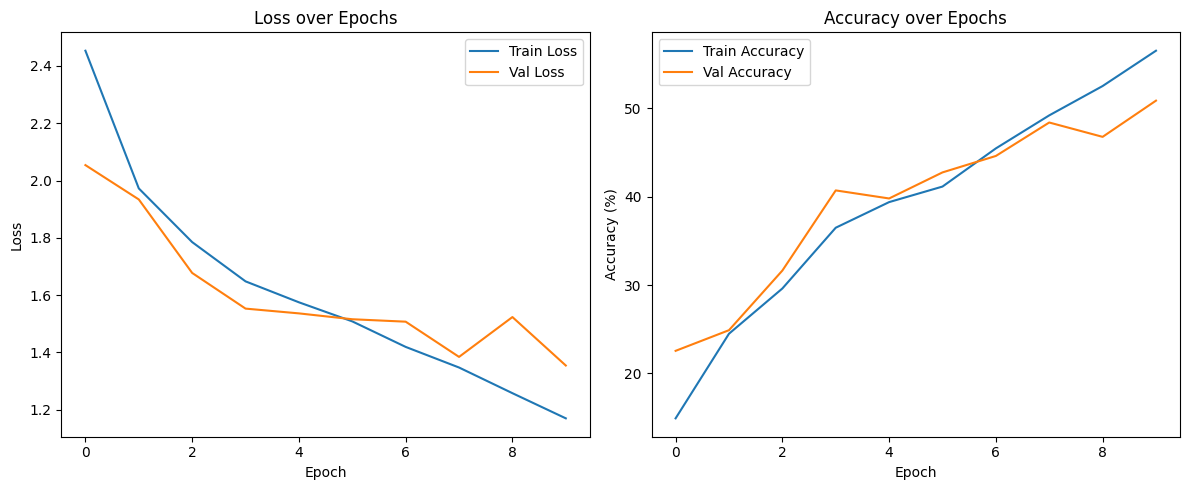

Final Train Accuracy: 56.54%
Final Validation Accuracy: 50.89%


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import models

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 10
batch_size = 128
learning_rate = 0.001

# STL-10 dataset with transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to match CaffeNet input
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),                 # Normalization values for 3 channels
                         (0.5, 0.5, 0.5))
])

# Download STL-10 dataset
train_dataset = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=transform)
test_dataset = torchvision.datasets.STL10(root='./data', split='test', download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load pretrained CaffeNet and modify the final layer for STL-10 (10 classes)
model = models.alexnet(pretrained=True)

# Modify the classifier to match STL-10's 10 classes
model.classifier[6] = nn.Linear(4096, 10)

# Move model to device (GPU/CPU)
model.to(device)

# Custom He + Orthogonal initialization
def custom_init(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')  # He initialization for conv layers
        elif isinstance(module, nn.Linear):
            nn.init.orthogonal_(module.weight)  # Orthogonal initialization for linear layers
        if hasattr(module, 'bias') and module.bias is not None:
            nn.init.constant_(module.bias, 0)  # Initialize bias to 0

# Apply custom initialization
custom_init(model)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training and validation function
def train_and_validate(model, num_epochs):
    train_acc_list, val_acc_list = [], []
    train_loss_list, val_loss_list = [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        correct_train, total_train, running_train_loss = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Training accuracy
        train_acc = 100 * correct_train / total_train
        train_acc_list.append(train_acc)
        train_loss_list.append(running_train_loss / len(train_loader))

        # Validation phase
        model.eval()
        correct_val, total_val, running_val_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        # Validation accuracy
        val_acc = 100 * correct_val / total_val
        val_acc_list.append(val_acc)
        val_loss_list.append(running_val_loss / len(test_loader))

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, '
              f'Train Loss: {train_loss_list[-1]:.4f}, Val Loss: {val_loss_list[-1]:.4f}')

    return train_acc_list, val_acc_list, train_loss_list, val_loss_list

# Run training and validation
train_acc, val_acc, train_loss, val_loss = train_and_validate(model, num_epochs)

# Plotting the results
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Final accuracy
print(f"Final Train Accuracy: {train_acc[-1]:.2f}%")
print(f"Final Validation Accuracy: {val_acc[-1]:.2f}%")
